# 1-D Inference with Redshifts

Part 2 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to derive population redshift distributions from a given collection of **redshift probability density functions (PDFs)**. This simple case allows us to introduce most of the critical ideas and extensions that serve as the foundation for $p$-D **photometric PDF** inference in later notebooks.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

seed(5)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [2]:
downsample = 10 # downsampling the population
sdss = pickle.load(open( "mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples[:,::downsample], sdss.samples_t[::downsample] # import truth labels
Nobs = sdss.NSAMPLES/downsample

## $dN/dz$ Estimation

### Noiseless Case

For every observed galaxy $g \in \mathbf{g}$, we have an associated redshift estimate $z_g$ with no measurement errors such that the corresponding redshift PDF is $P(z|z_g)=\delta(z-z_g)$. We can construct an estimate for the population redshift distribution by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z|z_h) , \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(z_g|z_h) \equiv P(g|h) = \int P(z|z_h) P(z|z_g) P(z) dz \quad .
$$

#### Histogram

One common choice of basis is a series of redshift **bins**, which can be modeled as a product of Heavyside functions

$$
P(z|z_h) = \mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z), \quad z_h^{\pm} = (z_h \pm \Delta z_h)/2
$$

where $z_h^{\pm}$ are the bin edges, $z_h$ is the bin center, and $\Delta z_h$ is the bin width. Assuming our redshift prior $P(z)$ is uniform, $P(g|h)$ then becomes $1$ if $z_h^{-} < z_g \leq z_h^{+}$ and $0$ otherwise.

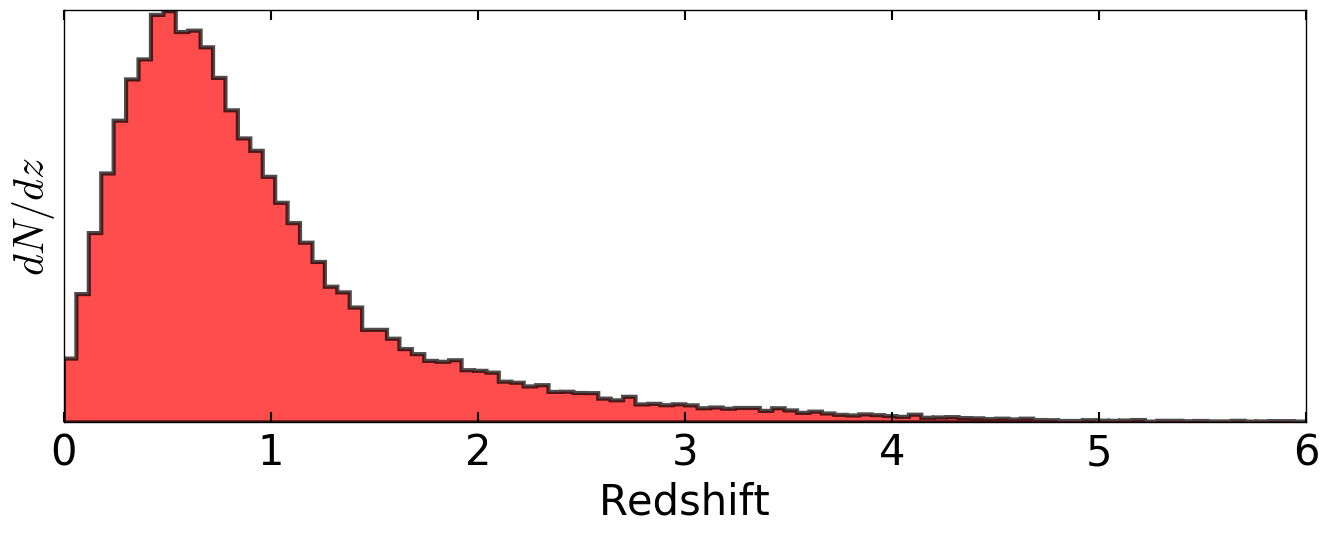

In [3]:
zbins = linspace(0,6,100+1) # redshift bins

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=3, color='red', alpha=0.7, normed=True)
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
tight_layout()

#### Kernel Density Estimation (KDE)

Alternately, we can construct a smooth density estimate by "flipping" the roles played by our $P(z|z_g)$'s and $P(z|z_h)$'s. Using **kernel density estimation**, we can approximate the underlying density spanned by all $z_g$'s by assigning each $z_g$ a corresponding kernel density $K_g(z|z_g)$.

Let's choose a Normal (Gaussian) kernel centered at $\hat{z}_g$ with smoothing scale $\sigma=0.01$ such that $P(z|z_g) = K_g(z|z_g)=\mathcal{N}(z|\mu=\hat{z}_g, \sigma^2=10^{-4})$, and $P(z|z_h)=\delta(z-z_h)$ to be the "redshift grid" (indexed by $h$) we use to evaluate our density estimate. Using some functionality from FRANKEN-Z, we compute and plot this below.

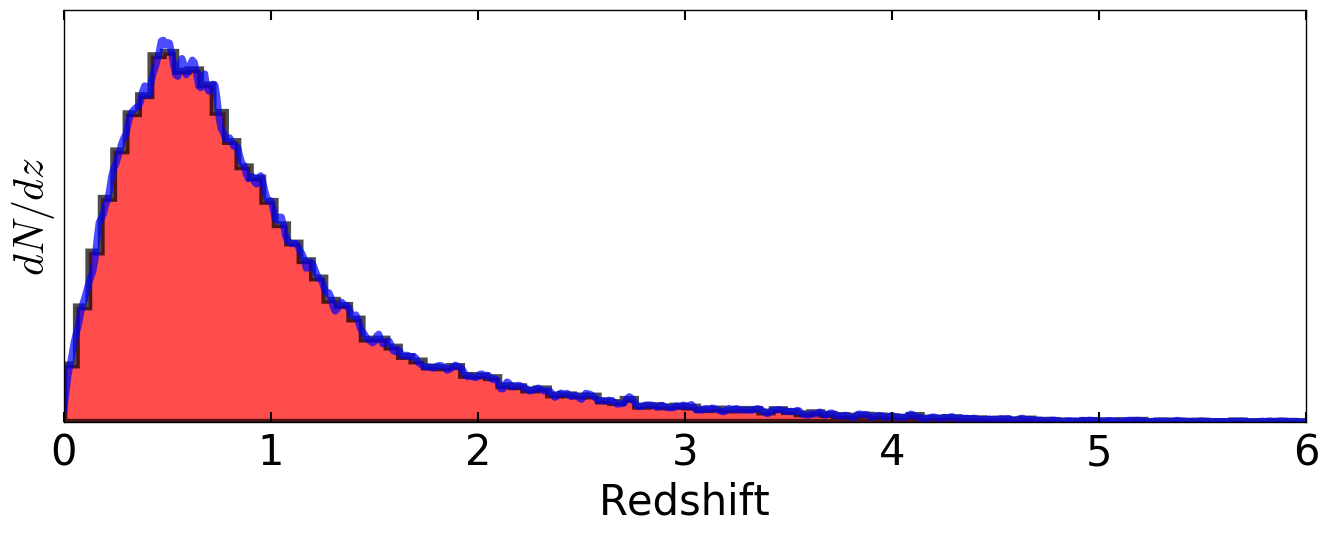

In [4]:
# redshift grid
dz, Nz = 0.01, 600+1
zgrid = arange(0, dz*Nz, dz)

# KDE
pdf = fz.pdf_kde(redshifts, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz)
pdf /= trapz(pdf, zgrid)

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=5, color='red', alpha=0.7, normed=True)
plot(zgrid, pdf, lw=5, color='blue', alpha=0.7)
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
tight_layout()

### Noisy Case

Now let's imagine that we don't actually have access to $z_g$, but only the corresponding redshift PDF $P(z|g)$ such that

$$
P(z_g|z_h) \equiv P(g|h) = \int \delta(z-z_h) P(z|g) P(z) dz = P(z_h|g) P(z) dz \quad .
$$

Functionally, we simulate this by defining our PDFs as kernels $K_g(z|z_g)$ centered around the noisy estimates $\hat{z}_g$ with variable $\sigma_g$.

In [5]:
# generate PDFs
sigma = uniform(0.01, 0.1, size=Nobs) # width
mu = normal(redshifts, sigma) # noisy observation
zpdf = array([fz.gaussian(mu[i], sigma[i], zgrid) for i in xrange(Nobs)]) # redshift pdfs
zpdf /= trapz(zpdf, zgrid)[:,None] # normalizing

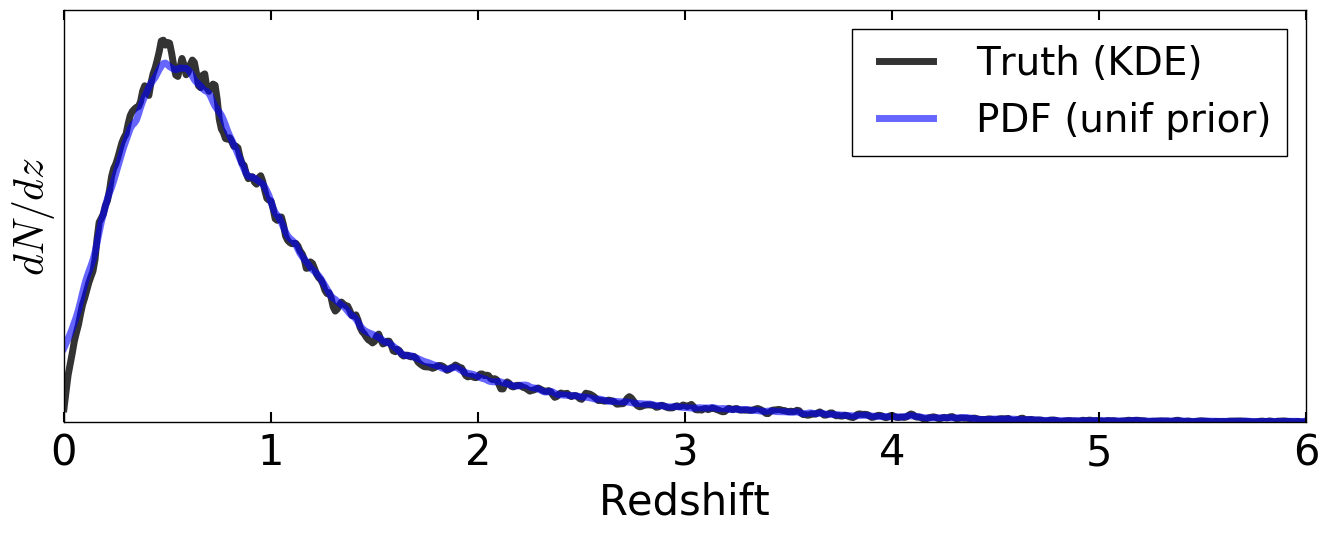

In [6]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0)/Nobs, lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see how our noise broadens our estimated $dN/dz$ distribution. To properly account for this, we need to re-introduce our **prior** $P(z)$. Over our redshift grid $\mathbf{z} = \lbrace \dots, z_h, \dots \rbrace$, this then gives

$$
P(\mathbf{z}|g) = \int \delta(z-\mathbf{z}) P(z|g) P(z) dz \propto \mathcal{N}(\mathbf{z}|\hat{z}_g, \sigma_g^2) P(\mathbf{z}) \quad .
$$

For our prior, let's put in the true redshift distribution computed previously using KDE.

In [7]:
znew = zpdf.copy()
for i in xrange(Nobs):
    znew[i] *= pdf
    znew[i] /= trapz(znew[i], zgrid)

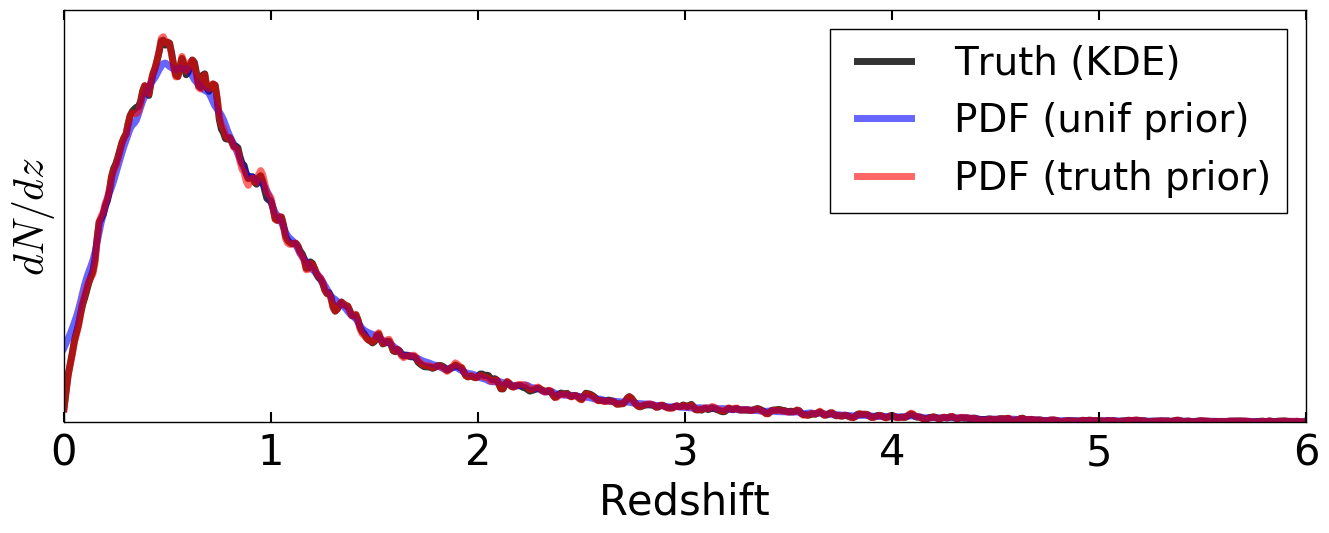

In [8]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0)/Nobs, lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
plot(zgrid, znew.sum(axis=0)/Nobs, lw=5, color='red', alpha=0.6, label='PDF (truth prior)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

As expected, computing the redshift posterior using the true, underlying prior distribution reproduces the original result.

## From Grids to Samples

So far we've assumed that our basis functions $h \in \mathbf{h}$ correspond to a grid in redshift $z_h \in \mathbf{z}$. Above, we found that to properly reproduce the true $dN/dz$ we need to incorporate a proper redshift prior $P(z)$. Given our discrete grid, this translates to a set of discrete priors $P(z_h) \equiv P(h)$ over $\mathbf{h}$, where our basis over $\mathbf{h}$ just happens to correspond to a grid in redshift $\mathbf{z}$. Adopting our original notation, this quickly gives rise to **Bayes theorem**

$$
P(h|g) = \frac{P(g|h) P(h)}{P(g)} \propto P(g|h) P(h)
$$

where

$$
P(g|h) \equiv \int P(z|h) P(z|g) dz, \quad P(h) = \frac{\int P(z|h) P(z|g) P(z) dz}{\int P(z|h) P(z|g) dz}, \quad P(g) = \sum_{h \in \mathbf{h}} P(g|h)P(h) \quad .
$$

For the case that $P(z|h) = \delta(z-z_h)$ (i.e. point estimates), this immediately reduces to $P(g|h) = P(z_h|g)$, $P(h) = P(z_h)$. If, however, our underlying set of basis functions are *not* point estimates, then we'd nominally have to compute the whole integral.

We now want to take advantage of two key insights:
1. Our choice of basis is arbitrary, and we're free to pick our $h \in \mathbf{h}$ and their corresponding $\lbrace \dots, P(z|h), \dots \rbrace$ however we'd like (in general), and
2. Our basis can provide information on our prior.

In particular, if we assume that $h \in \mathbf{h}$ is a **(Poisson) point process** drawn from the underlying $P(z)$ distribution (i.e. the "true" prior), then aggregating information over these redshift samples is *fundamentally equivalent* (in the limit where $n \rightarrow \infty$) to weighting a set of predictions computed over a redshift grid $\mathbf{z}$ by our corresponding prior $P(\mathbf{z})$.

From a machine learning perspective, we can interpret these samples as a **training set** that we exploit to make predictions. See Speagle et al. (2017) for more details.

### Noiseless Samples

We first consider the case where our samples are noiseless and drawn directly from the redshift distribution of interest. Our log-likelihood then becomes

$$
\chi^2(g|h) \equiv -2\ln P(g|h) = -2\ln \left[ \int P(z|h) P(z|g) dz \right] = -2\ln \left[ \int \delta(z-z_h) \mathcal{N}(z|\hat{z}_g, \sigma_g^2) dz \right] = -2\ln \left[ \mathcal{N}(\hat{z}_g-z_h|0,\sigma_g^2) \right] = \frac{(\hat{z}_g-z_h)^2}{\sigma_g^2} \quad .
$$

In [9]:
Ntrain = 1000 # number of training samples

In [10]:
cdf = pdf.cumsum()/pdf.sum() # compute CDF
ztrain = interp(rand(Ntrain), cdf, zgrid) # sample from underlying distribution

In [11]:
# stack results
ztrain_wt = zeros(Ntrain)
znorm = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = ((ztrain - mu[i]) / sigma[i])**2
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm[i] = norm / exp(-0.5*chi2min)
    ztrain_wt += wt/norm

0 20000 40000 

We then can estimate $dN/dz$ as before using KDE.

In [12]:
# KDE
pdftrain = fz.pdf_kde(ztrain, ones(Ntrain)*dz, ztrain_wt, zgrid, dz, Ntrain, Nz)
pdftrain /= trapz(pdftrain, zgrid)

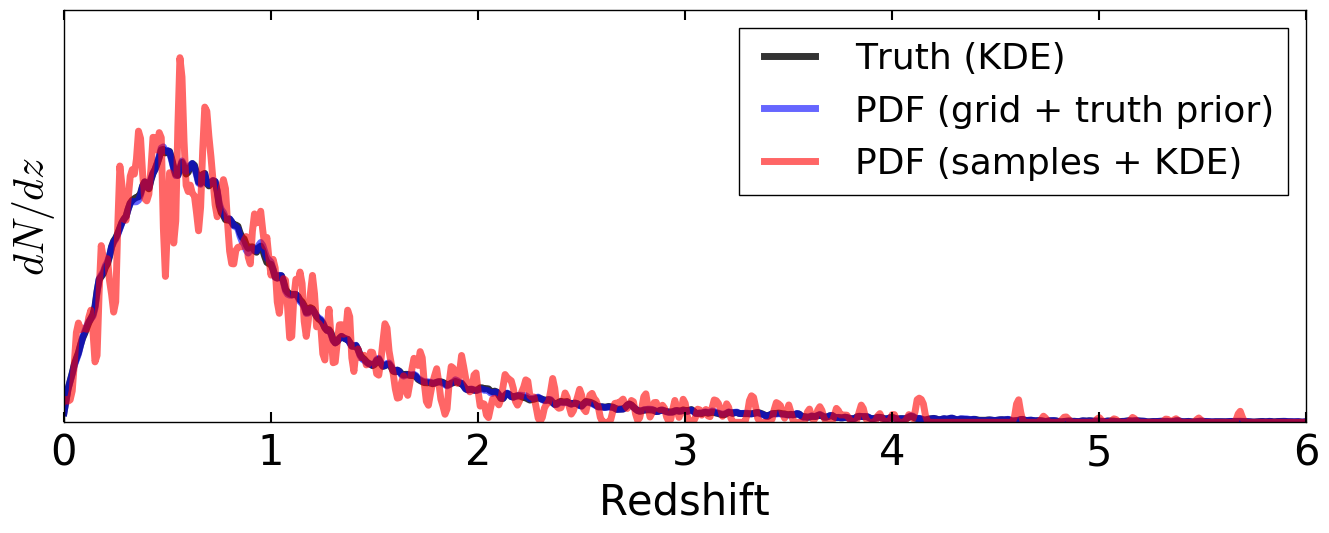

In [13]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, znew.sum(axis=0)/Nobs, lw=5, color='blue', alpha=0.6, label='PDF (grid + truth prior)')
plot(zgrid, pdftrain, lw=5, color='red', alpha=0.6, label='PDF (samples + KDE)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

While this estimate is accurate overall, it's subject to a some additional noise due to sampling variance. As a result, it relies on there being a *lot* of samples available for estimation, especially if we want to probe the tails of the redshift distribution.

### Noisy Samples

We now consider the case where our samples/training data are *also* noisy redshift estimates characterized by $P(z|h)$. As with the switch from noiseless to noisy redshifts for $g \in \mathbf{g}$, we again model this switch for $h \in \mathbf{h}$ by modeling our PDFs as kernels can with noisy redshifts and variables widths. The log-likelihood then becomes

$$
\chi^2(g|h) = \frac{(\hat{z}_g-\hat{z}_h)^2}{\sigma_g^2+\sigma_h^2} \quad .
$$

In [14]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)

# generate PDFs
sigma_train = uniform(0.01, 0.1, size=Ntrain) # width
var_train = sigma_train**2
mu_train = normal(ztrain, sigma_train) # noisy observation

In [15]:
# stack results
ztrain_wt2 = zeros(Ntrain)
znorm2 = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (mu_train - mu[i])**2 / (sigma[i]**2 + var_train)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm2[i] = norm / exp(-0.5*chi2min)
    ztrain_wt2 += wt/norm

0 20000 40000 

We now stack the corresponding kernels.

In [16]:
# KDE
pdftrain2 = fz.pdf_kde(mu_train, sigma_train, ztrain_wt2, zgrid, dz, Ntrain, Nz)
pdftrain2 /= trapz(pdftrain2, zgrid)

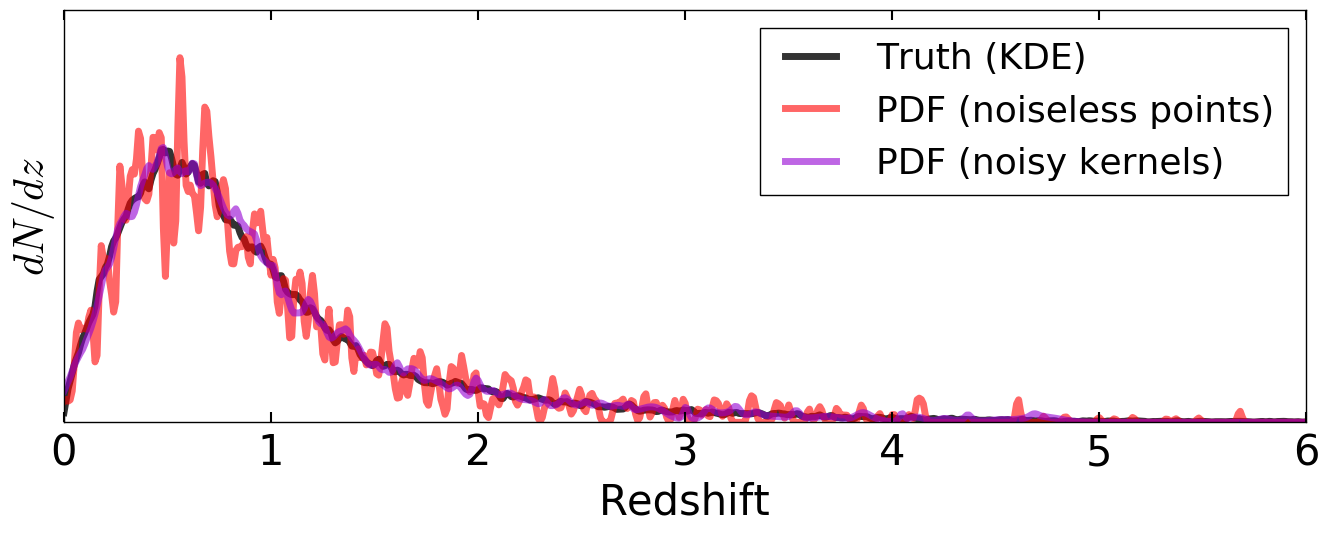

In [17]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

By eye, it can immediately be seen that our PDF using the same number of "noisy" samples is actually a much better representation than our PDF using noiseless samples. What gives?

There are three reasons for this:
1. It makes a difference whether a probabilistic basis is incorporated directly into the likelihoods or implemented afterwards. In the noiseless case, we applied KDE afterwards rather than assigning each object its own kernel when deriving our likelihoods, which ignores the intrinsic width of the kernel.
2. The smoothing scale for our inference is set by the width of our kernels. In the noiseless case, we chose the same smoothing scale ($\Delta z = 0.01$) used for our grid, while for the noisy case our smoothing scale varies from $\Delta z = 0.01 - 0.1$. This sets the scale for variation, and since the total number of samples we are using is relatively small, we would expect a broader smoothing scale to give better results in general.
3. While each individual PDF from our noisy sample is a noisy draw from the underlying density, across the ensemble the noise generally averages out, giving an unbaised representation of the true underlying distribution.

Just to demonstrate the impact of these effects, we use a series of broader noiseless kernels to re-derive our original noiseless $dN/dz$ below.

In [18]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)
smooth = 0.05

# stack results
ztrain_wt3 = zeros(Ntrain)
znorm3 = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (ztrain - mu[i])**2 / (sigma[i]**2 + smooth**2)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm3[i] = norm / exp(-0.5*chi2min)
    ztrain_wt3 += wt/norm

0 20000 40000 

In [19]:
# KDE
pdftrain3 = fz.pdf_kde(ztrain, ones(Ntrain)*smooth, ztrain_wt3, zgrid, dz, Ntrain, Nz)
pdftrain3 /= trapz(pdftrain3, zgrid)

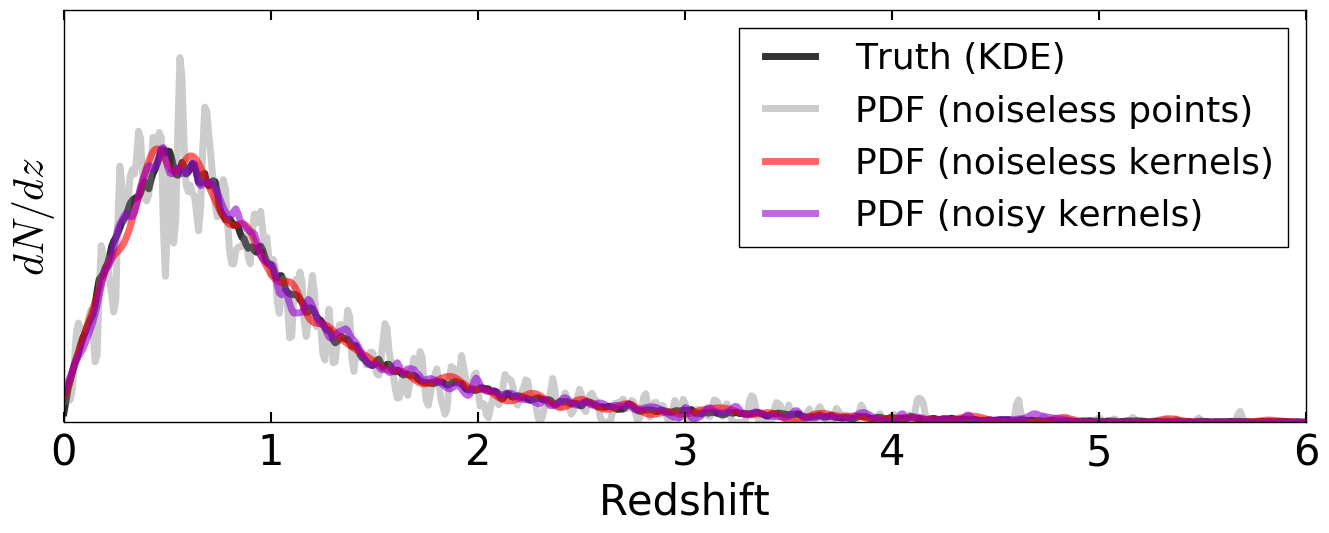

In [20]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='gray', alpha=0.4, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain3, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless kernels)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

As expected, we do a significantly better job recovering the underlying distribution once we properly incorporate a set of broader kernels directly into our likelihoods.

## Sidenote: Coverage

One of the risks that becomes immediately apparent moving from grids to samples is the issue of **coverage**. In other words, our training data may not adequately cover all of the space spanned by our observable PDFs. We can diagnose this by looking at the **evidence** $P(g)$ (i.e. the normalization term we've ignored up until now!) computed for our objects. This gives a direct probe that tells us how much of our $\lbrace \dots, P(z|h), \dots \rbrace$ basis overlaps with each individual $P(z|g)$. We can then choose a given threshold (say $P(g)>0.05$, i.e. that our kernels cumulatively overlap with at least 5% of the observed PDF) that signifies whether a given prediction can or cannot be "trusted".

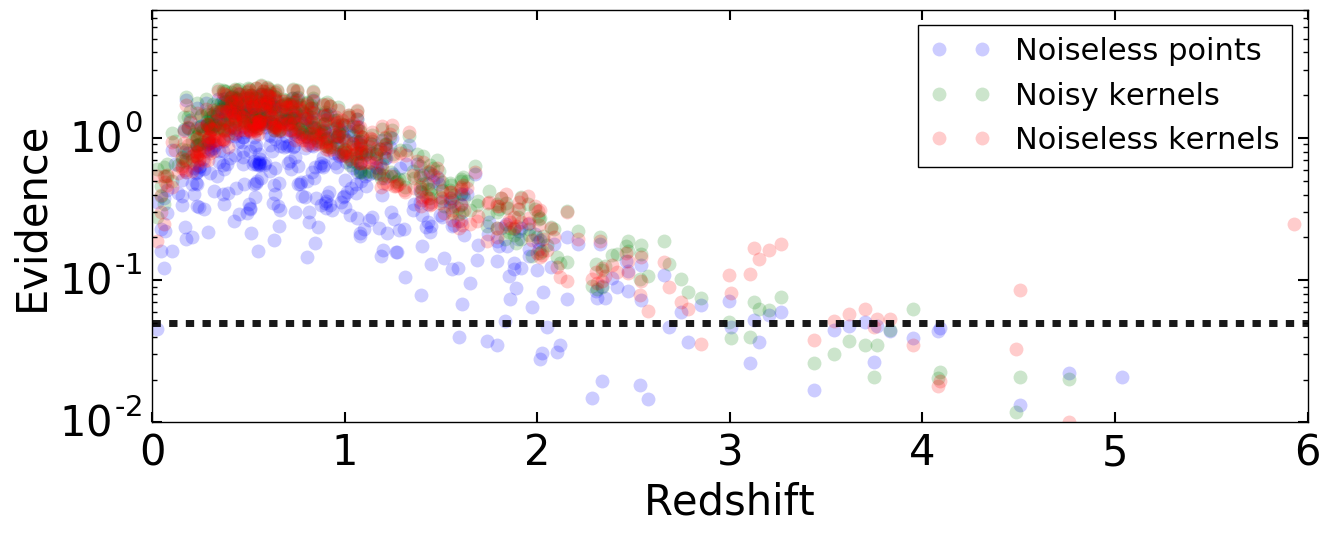

In [21]:
figure(figsize=(14,6))
semilogy(redshifts[::100], znorm[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless points', markeredgecolor='none')
semilogy(redshifts[::100], znorm2[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noisy kernels', markeredgecolor='none')
semilogy(redshifts[::100], znorm3[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless kernels', markeredgecolor='none')
plot([0,6], [0.05, 0.05], color='black', lw=5, alpha=0.9, ls='--')
xlabel('Redshift')
ylim([None, 8])
ylabel('Evidence')
legend(fontsize=22, loc=1)
tight_layout()

As expected, this distribution traces the underlying redshift distribution (since we've sampled from the underlying redshift distribution), and we can see that in both cases several observed objects do not have enough coverage for our predictions be considered reliable.

## Hierarchical Bayesian Model

We now want to derive *errors* around our $dN/dz$ predictions from our underlying PDFs. In particular, we want to generate a series of posterior $dN/dz$ samples.

To start, we're going to go back to our model grid over our point process since inference is more intuitive in that domain.

### Poisson Samples

A common approximation is that the amplitude at each redshift is simply a counting (Poisson) process, with errors that go as $\sqrt{N}$. This is technically incorrect since it assumes the distribution around the sum is the same as the sum of the distributions, but often is invoked as a first-order approximation.

In [22]:
Nsamples = 20 # number of dN/dz samples

In [23]:
pdf1 = zpdf.sum(axis=0) # stacked PDF
pdf1 /= pdf1.sum() # normalize
pdf1 *= Nobs # sample size
pdf1_samples = array([poisson(pdf1) for i in xrange(Nsamples)]) # samples

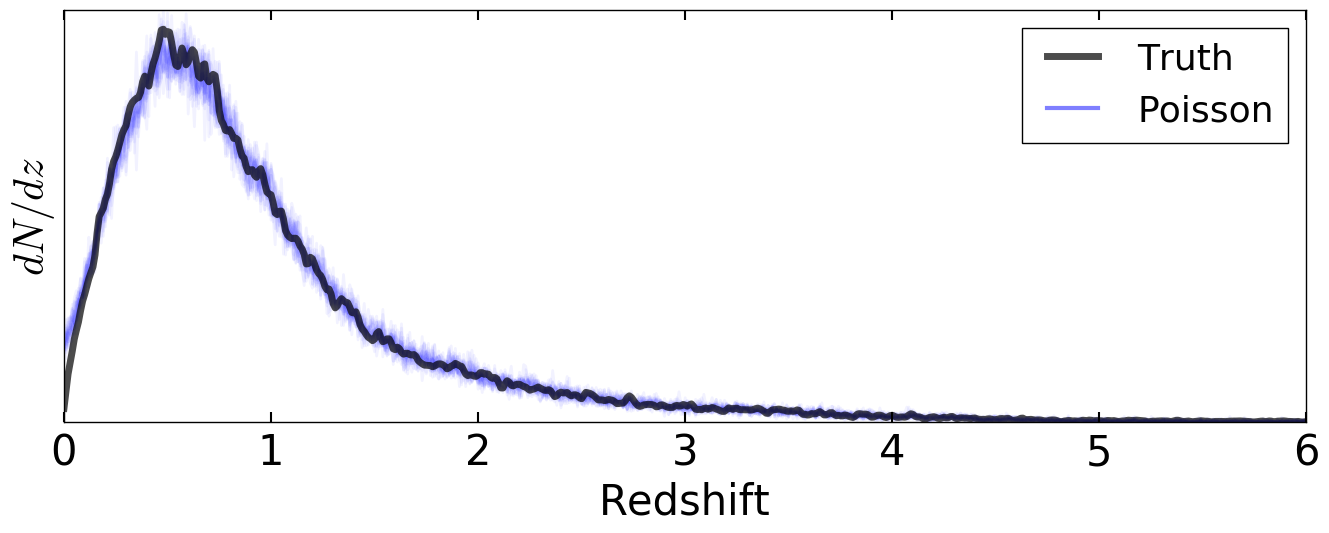

In [24]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Posterior Samples

Any particular galaxy $g$ is located at a particular redshift $z_g$ which is distributed as

$$
z_g \sim \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right)
$$

where $\textrm{Mult}\left[n, \mathbf{p}\right]$ is the **Multinomial distribution** with $n$ draws from $N_p$ categories with corresponding probabilities $\mathbf{p}$ and $\mathbf{p}_g \equiv P(\mathbf{z}|g)$. The redshift number density posterior $\mathbf{n}$ over $\mathbf{z}$ is then

$$
\mathbf{n} \sim \sum_{g \in \mathbf{g}} \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right) \quad .
$$

We can draw samples $\mathbf{n}^{(i)}$ from our posterior by iteratively sampling from the underlying PDFs and then stacking the results.

In [25]:
pdf2_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(str(j)+' ')
    for i in xrange(Nobs):
        pdf2_samples[j] += multinomial(1, zpdf[i]/zpdf[i].sum()) # stack multinomial draw

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

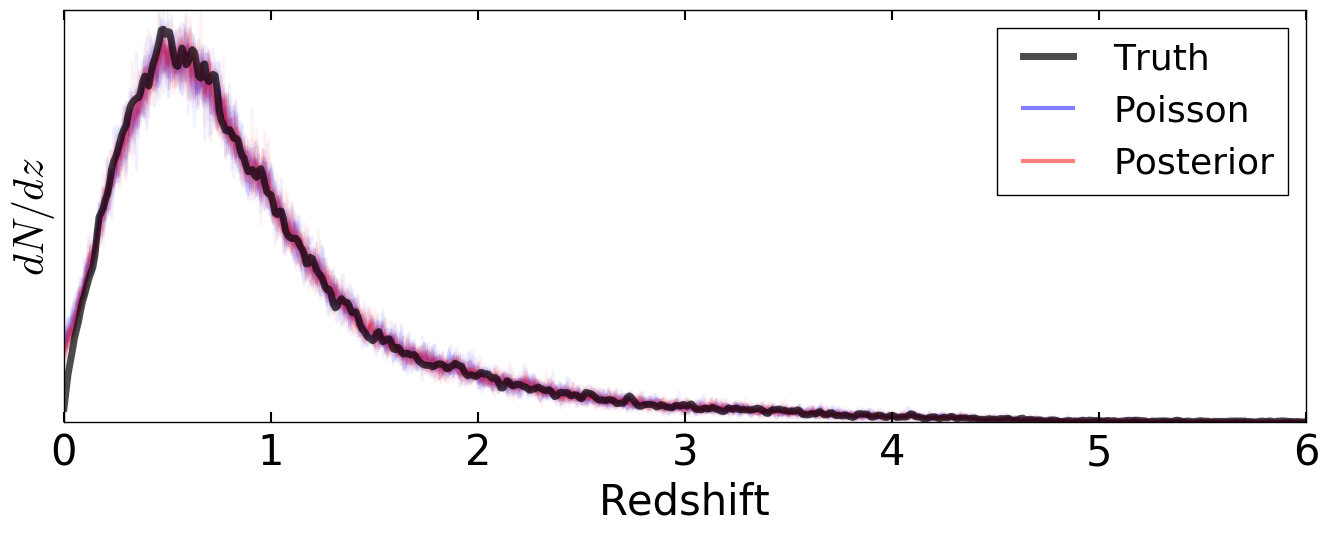

In [26]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.05) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Population Weights

Given a probability vector $\mathbf{p}$, an individual galaxy $z_g$ is distributed as $z_g \sim \textrm{Mult}\left[1, \mathbf{p}\right]$. However, given a dataset with $N$ objects with corresponding number densities $\mathbf{n}$ across our $N_p$ categories that we use to estimate $\mathbf{p}$, our probability vector $\mathbf{p}$ can be shown (Speagle et al. 2017) to be distributed as 

$$ 
\mathbf{p} \sim \textrm{Dir}\left(\mathbf{p} | \boldsymbol{\alpha} = \mathbf{n}+1 \right)
$$

where $\textrm{Dir}\left(\mathbf{p}|\boldsymbol{\alpha}\right)$ is the **Dirichlet distribution** with concentration parameter $\boldsymbol{\alpha}$ across our categories. In general, this tends to upweight our tails and downweight the peak. For $n \in \mathbf{n}$ small, this makes the distribution more uniform/flat; for $n$ large, the impact is small.

We now define a set of redshift **population weights** $\mathbf{w}$ corresponding to our redshift bins $\mathbf{z}$ whose posterior distribution is

$$
\mathbf{w} \sim \textrm{Dir}\left(\mathbf{w} | \boldsymbol{\alpha} = \mathbf{n}+1 \right), \quad \mathbf{n} \sim \sum_{g \in \mathbf{g}} \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right) \quad .
$$

We can draw samples from our posterior by iteratively sampling $z_g^{(i)}$ from the underlying PDFs, stacking the results to get $\mathbf{n}^{(i)}$, and then sampling $\mathbf{w}^{(i)}$ from our final Dirichlet.

In [27]:
pdf3_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(str(j)+' ')
    for i in xrange(Nobs):
        pdf3_samples[j] += multinomial(1, zpdf[i]/zpdf[i].sum()) # stack multinomial draw
    pdf3_samples[j] = dirichlet(pdf3_samples[j] + 1) * Nobs # sample population weight

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

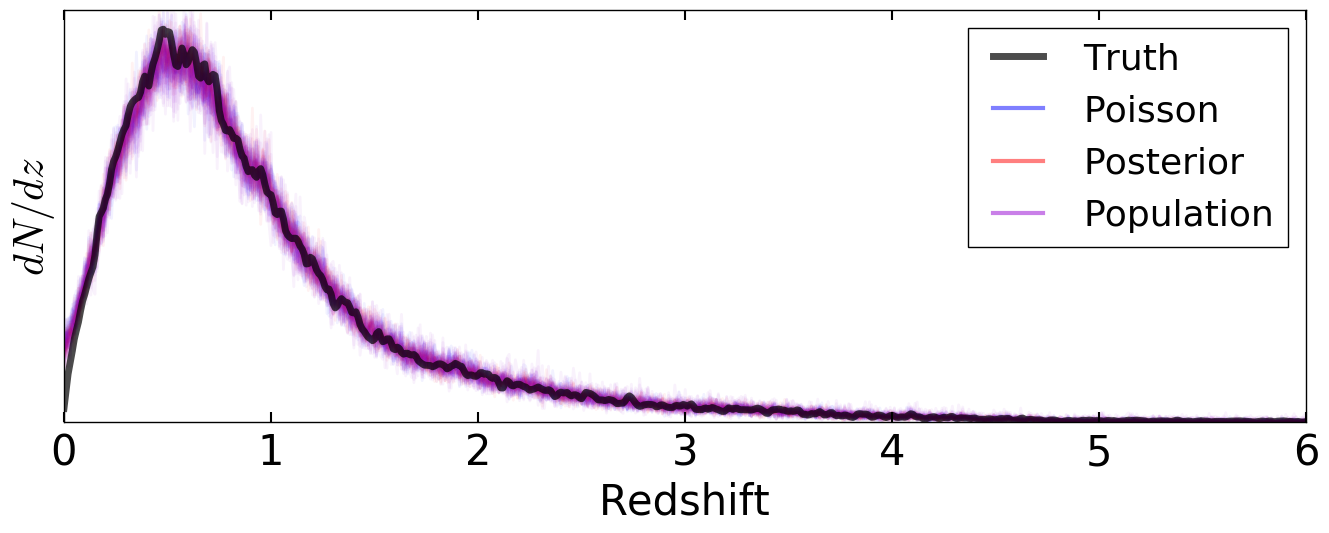

In [28]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.05) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

### Hierarchical Inference

The last step is to go from our conditional population model to a full hierarchical model. In other words, rather than sampling from $P(\mathbf{w}|\lbrace \dots, \mathbf{p}_g, \dots \rbrace)$, we want to sample from the **joint distribution** $P(\mathbf{w}, \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. 

This in general is intractable for typical Metropolis-style **Markov Chain Monte Carlo (MCMC)** samplers that probe the $(N_h + N_g)$-parameter joint distribution directly. It is, however, particularly amenable to **Gibbs sampling**. We can thus sample from distribution by iteratively sampling from $P(\lbrace \dots, \mathbf{p}_g, \dots \rbrace | \mathbf{w})$ and $P(\mathbf{w} | \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. Assuming **Poisson independence** for all $g \in \mathbf{g}$, we can draw our posterior samples via

\begin{align}
\textrm{Sample individual redshifts:}& \quad \lbrace \dots, \mathbf{\hat{p}}_g^{(i)}, \dots \rbrace \sim \left\lbrace \dots, \textrm{Mult}\left( n=1, \mathbf{p}=\mathbf{p}_g \bullet \mathbf{w}^{(i-1)} \right), \dots \right\rbrace \\
\textrm{Compute number density:}& \quad \mathbf{n}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{\hat{p}}_g^{(i)} \\
\textrm{Sample population weights:}& \quad \mathbf{w}^{(i)} \sim \textrm{Dir}\left(\mathbf{w} | \mathbf{n}^{(i)} + 1\right) \quad .
\end{align}

In [29]:
# generate samples
Nmcmc = 2000 # total number of MCMC draws
pdf4_samples = zeros((Nmcmc, Nz))

wt = ones(Nz) # initialize weights
for j in xrange(Nmcmc):
    if j%10==0: sys.stdout.write(str(j)+' ')
    pstack = zeros(Nz)
    zpdf_t = zpdf * wt # compute new posterior
    zpdf_t /= zpdf_t.sum(axis=1)[:,None] # normalize
    for i in arange(Nobs):
        pstack += multinomial(1, zpdf_t[i]) # stack multinomial draw
    wt = dirichlet(pstack + 1) * Nobs # sample population weight
    pdf4_samples[j] = wt.copy() # store result

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 

As with any MCMC sampler, we need time to "burn in" to the stationary distribution and often some subsequent thinning of the to ensure more independent samples. We check both of these conditions below by looking at the autocorrelation time for a few of our redshift grid points, the general autocorrelation for $\Delta t=1$, and a few traces of our samples.

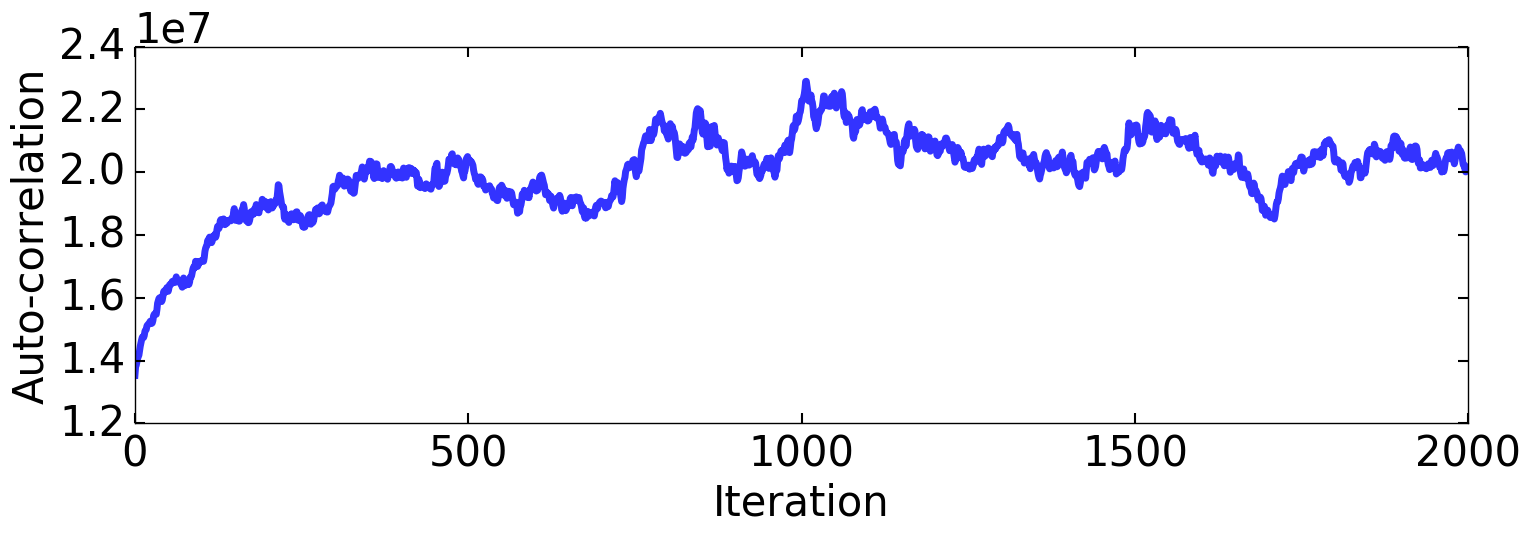

In [30]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(pdf4_samples[i], pdf4_samples[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
xlim([0, Nmcmc])
tight_layout()

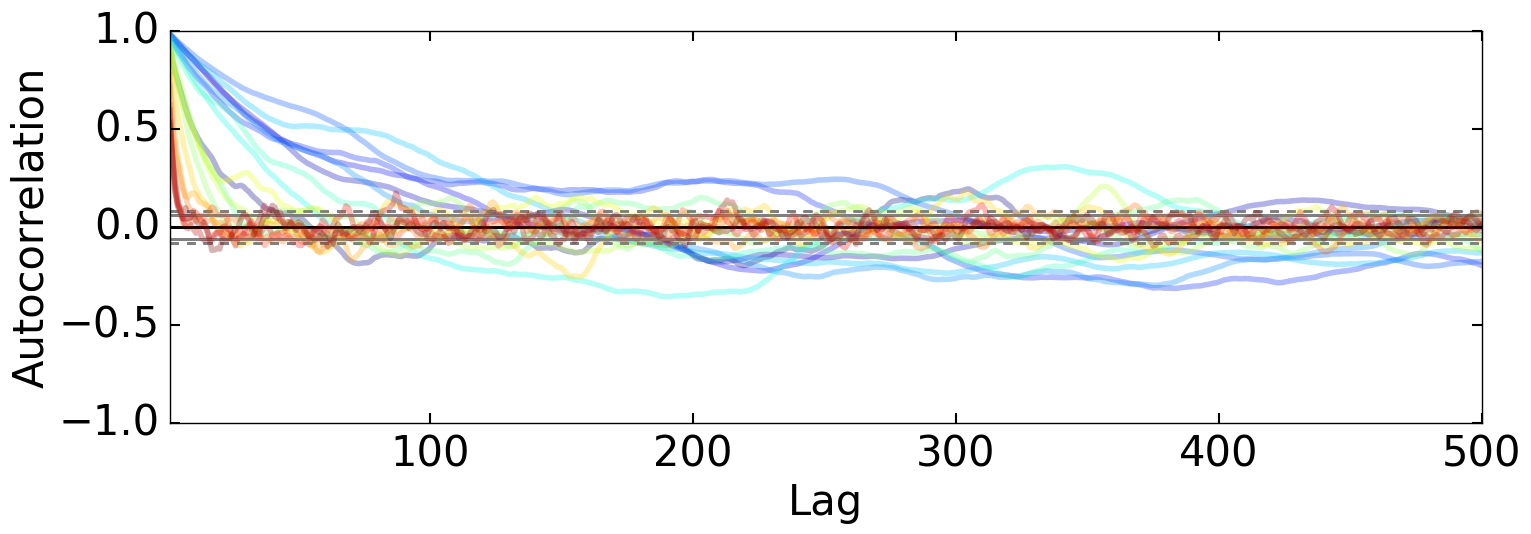

In [31]:
# plot autocorrelation lag
Nburnin = 1000
figure(figsize=(16,6))
colors=get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(pdf4_samples[Nburnin:,i*(Nz/20)], color=colors[i], lw=4, alpha=0.3) for i in xrange(20)]
xlim([1, (Nmcmc-Nburnin)/2])
tight_layout()

In [32]:
# thinning
Nthin = 50
pdf4_samples_t = pdf4_samples[Nburnin::Nthin]

Now let's take a look at our final results.

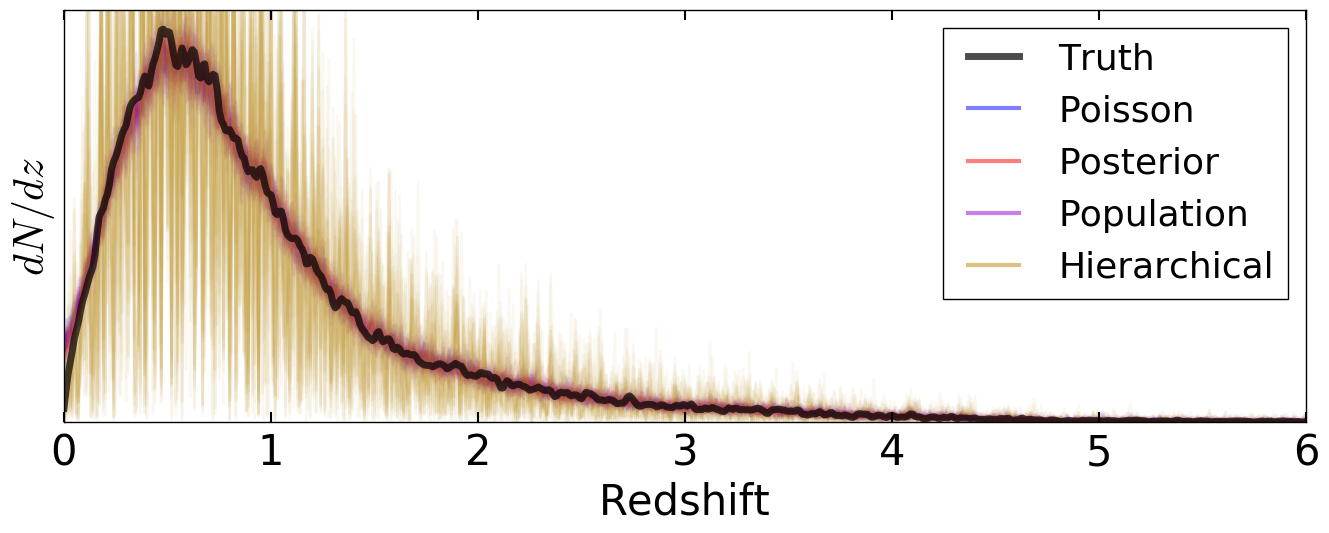

In [33]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf4_samples_t[i], lw=2, color='darkgoldenrod', alpha=0.05) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

Our hierarchical sample appears to experience some enourmous variation! There are a few primary reasons for this. Most crucially, our Dirichlet distribution is fundamentally an unordered distribution. By disregarding the fact that the amplitude of nearby redshift bins should inherently be strongly correlated with each other, it allows for more variation than might otherwise be possible. In addition, our PDFs are relatively broad compared to the resolution of our redshift grid (encompassing 2-20 bins out of 601), especially given the size of our sample (100k galaxies). This lends itself to a lot of possible sample variation.

These very noisy results, however, still can be leveraged to give good predictions at coarser resolutions, as shown below.

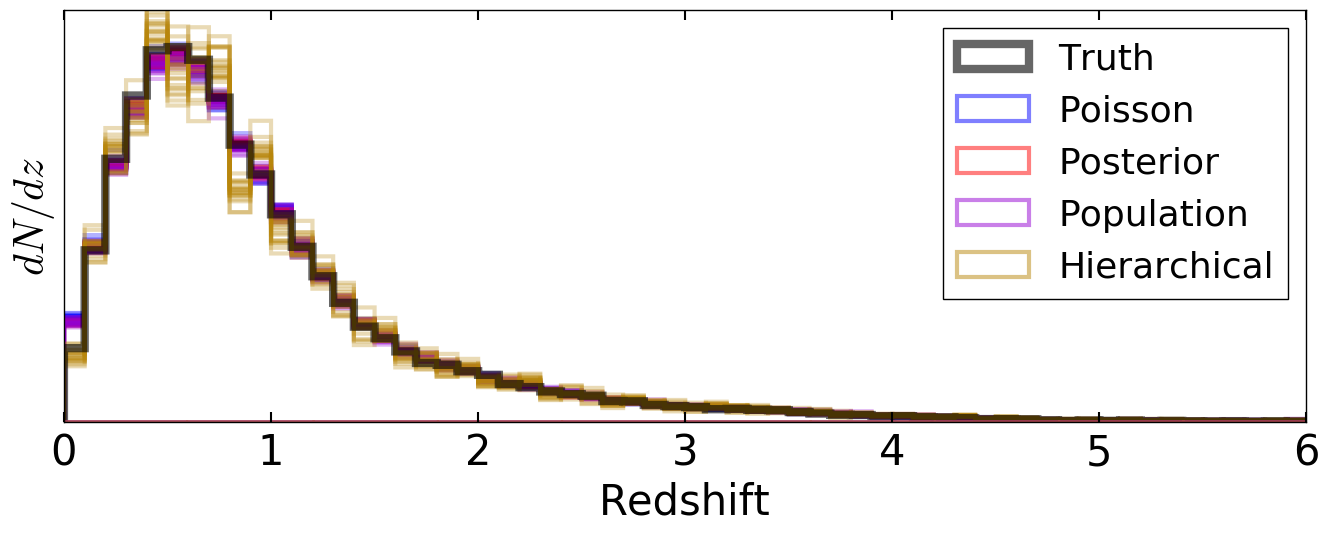

In [34]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pdf1_samples[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf2_samples[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf3_samples[i], lw=3, histtype='step', color='darkviolet', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf4_samples_t[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in xrange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = pdf/pdf.sum() * Nobs, histtype='step', 
         lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Population')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

While the errors for our original distributions increase as we transition from Poisson samples to posterior draws to Dirichlet-based population weights, only our hierarchical model is able to properly recover the true underlying distribution (and give a much more realistic error distribution).

Another way to visualize our results is by looking at the covariances between neighboring redshift bins.

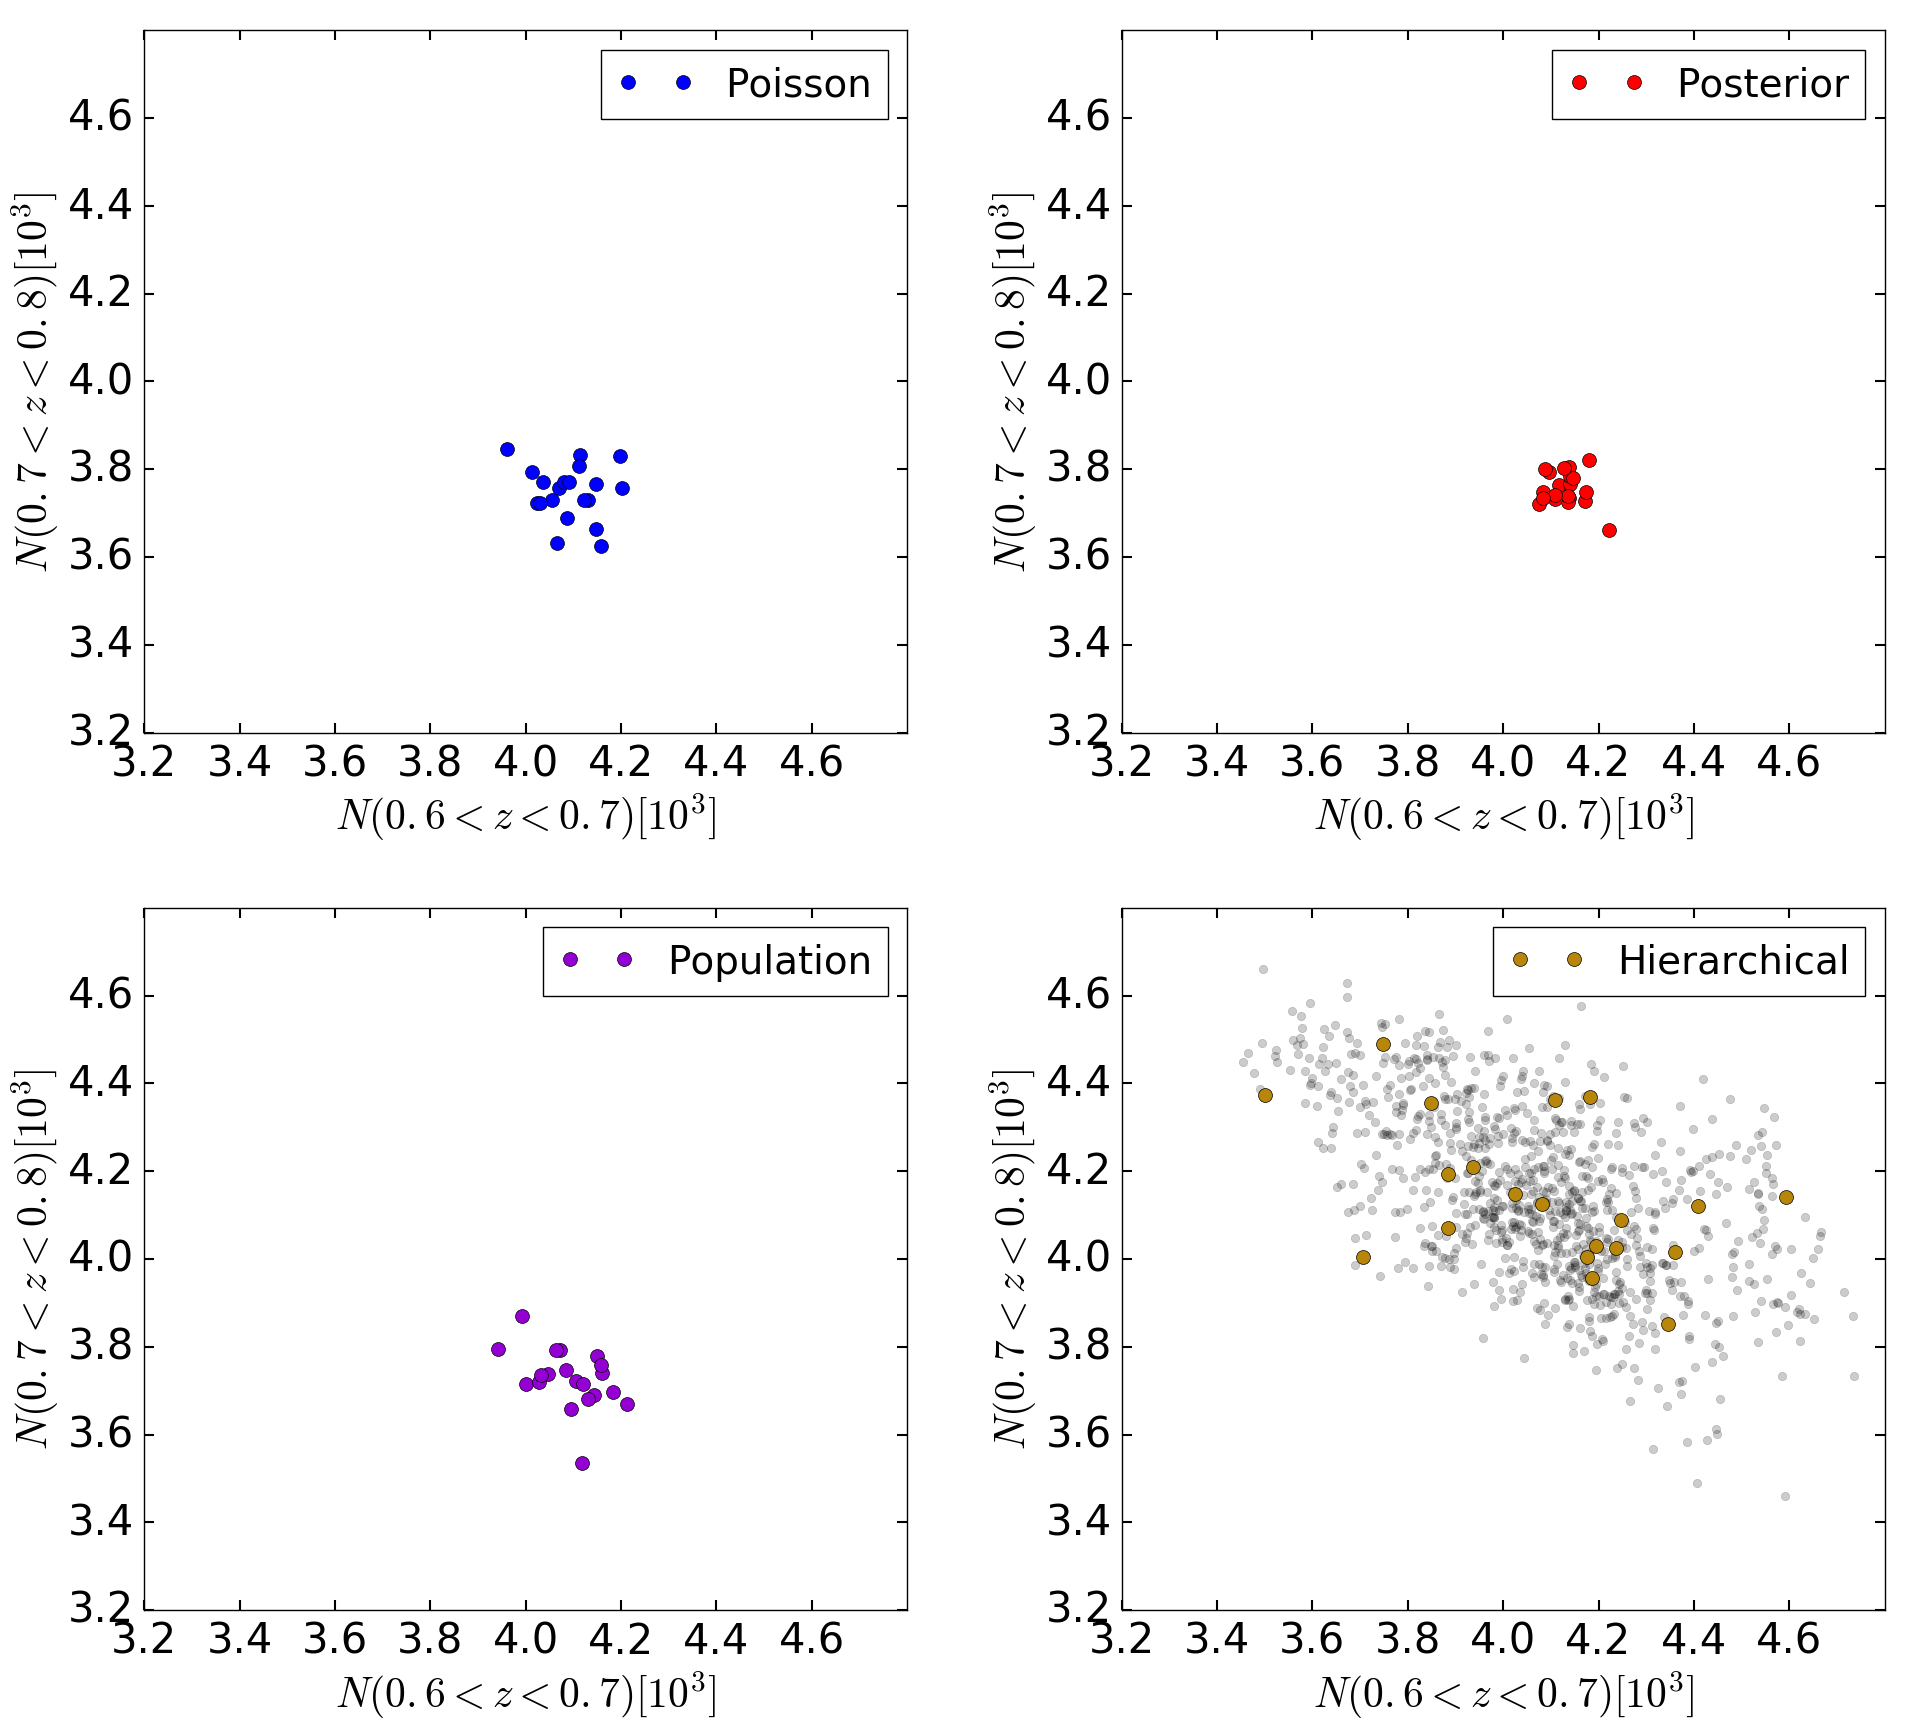

In [35]:
figure(figsize=(20,18))
subplot(2,2,1)
plot(pdf1_samples[:,60:70].sum(axis=1)/1e3, pdf1_samples[:,70:80].sum(axis=1)/1e3, 'o', color='blue', label='Poisson', 
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
plot(pdf2_samples[:,60:70].sum(axis=1)/1e3, pdf2_samples[:,70:80].sum(axis=1)/1e3, 'o', color='red', label='Posterior',
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
plot(pdf3_samples[:,60:70].sum(axis=1)/1e3, pdf3_samples[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', label='Population',
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
plot(pdf4_samples[Nburnin:,60:70].sum(axis=1)/1e3, pdf4_samples[Nburnin:,70:80].sum(axis=1)/1e3, 'o', 
     color='black', alpha=0.2)
plot(pdf4_samples_t[:,60:70].sum(axis=1)/1e3, pdf4_samples_t[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

Our behavior is as we expect: our Poisson model, which draws samples independently from the population, is not correlated. Our posterior model is anti-correlated between the bins, since as objects scatter out of one bin they're likely to scatter into the neighboring bin. Our population distribution is still anti-correlated but has a broader spread due to the variation between neighboring bins induced by our Dirichlet draws. Finally, our hierarchical model is not only offset from our original predictions, but also shows the most variable behavior and strongest (anti-)correlation. This better captures the intrinsic uncertainties present in our sample and the behavior of our population due to individual objects scattering around from bin to bin.

## Hierarchical Point Process

We now broaden our model to include an arbitrary basis of training objects with noisy redshift kernels. For simplicity, we use the same sample of 1000 training objects from earlier.

In [36]:
# stack results
like = zeros((Nobs, Ntrain))
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (mu_train - mu[i])**2 / (sigma[i]**2 + var_train)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    like[i] = wt/wt.sum()

0 20000 40000 

Since we now have likelihoods computed over a series of training objects using only our observables, we can now formulate our models directly in the **training data space**. After we draw our set of samples, it is then straightforward to map our results onto our target distribution of choice (i.e. redshift).

In [38]:
# stack likelihoods
lstack = like.sum(axis=0)

In [47]:
# Poisson
train1_samples = array([poisson(lstack) for i in xrange(Nsamples)]) # draw object
z1_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    Nsamps = train1_samples[i].sum()
    for j in xrange(Ntrain):
        for k in xrange(train1_samples[i][j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z1_samples[i] = fz.pdf_kde(zsamps, ones(Nsamps)*dz, ones(Nsamps), zgrid, dz, Nsamps, Nz) # KDE
    z1_samples[i] *= (Nsamps / z1_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [48]:
# Posterior
train2_samples = zeros(train1_samples.shape, dtype='int')
z2_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    for j in xrange(Nobs):
        train2_samples[i] += multinomial(1, like[j]) # draw object samples
    for j in xrange(Ntrain):
        for k in xrange(train2_samples[i][j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z2_samples[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z2_samples[i] *= (Nobs / z2_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [49]:
# Population
train3_samples = zeros(train1_samples.shape)
z3_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    for j in xrange(Nobs):
        train3_samples[i] += multinomial(1, like[j])
    train3_samples[i] = dirichlet(train3_samples[i] + 1) * Nobs # draw population weights
    draw = multinomial(Nobs, train3_samples[i]/train3_samples[i].sum()) # draw object samples
    for j in xrange(Ntrain):
        for k in xrange(draw[j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z3_samples[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z3_samples[i] *= (Nobs / z3_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

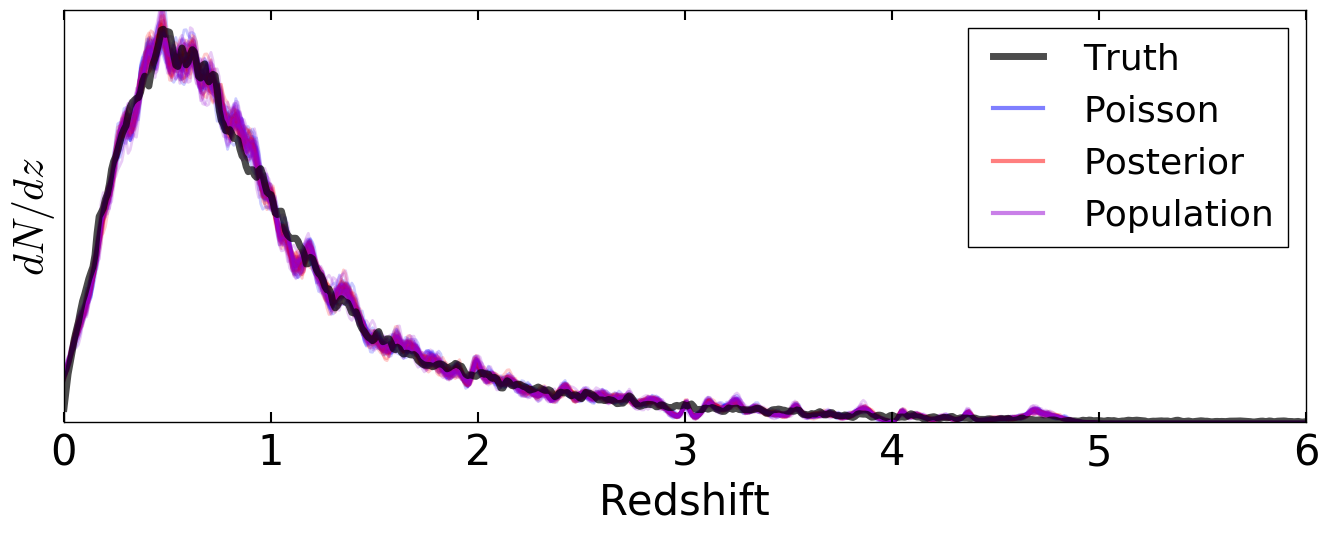

In [60]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, z1_samples[i], lw=2, color='blue', alpha=0.2) for i in xrange(Nsamples)]
[plot(zgrid, z2_samples[i], lw=2, color='red', alpha=0.2) for i in xrange(Nsamples)]
[plot(zgrid, z3_samples[i], lw=2, color='darkviolet', alpha=0.2) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

While there is some variation between the draws in both the training object space and the target redshift space, in general our results here give consistent answers with each other.

How does our hierarchical model do?

In [66]:
# Hierarchical
Nmcmc = 2000 # total number of MCMC draws
train4_samples = zeros((Nmcmc, Ntrain))
z4_samples = zeros((Nmcmc, Nz))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    if i%10==0: sys.stdout.write(str(i)+' ')
    zsamps = []
    like_t = like * wt # compute new posterior
    like_t /= like_t.sum(axis=1)[:,None] # normalize
    for j in arange(Nobs):
        train4_samples[i] += multinomial(1, like_t[j])
    train4_samples[i] = dirichlet(train4_samples[i] + 1) * Nobs # draw population weights
    wt = train4_samples[i].copy()
    draw = multinomial(Nobs, wt/wt.sum()) # draw object samples
    for j in xrange(Ntrain):
        for k in xrange(draw[j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z4_samples[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z4_samples[i] *= (Nobs / z4_samples[i].sum()) # normalize

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 

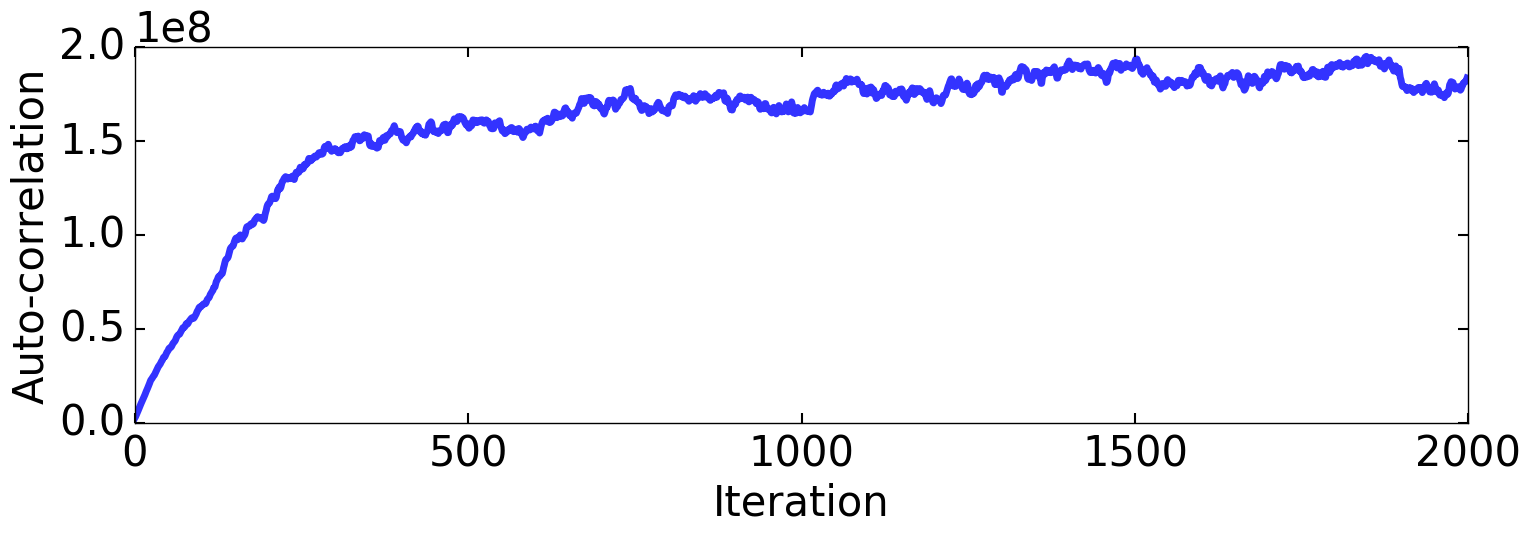

In [67]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(train4_samples[i], train4_samples[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
xlim([0, Nmcmc])
tight_layout()

Now let's examine the traces of the training objects with the largest contributions to the posterior after burn-in.

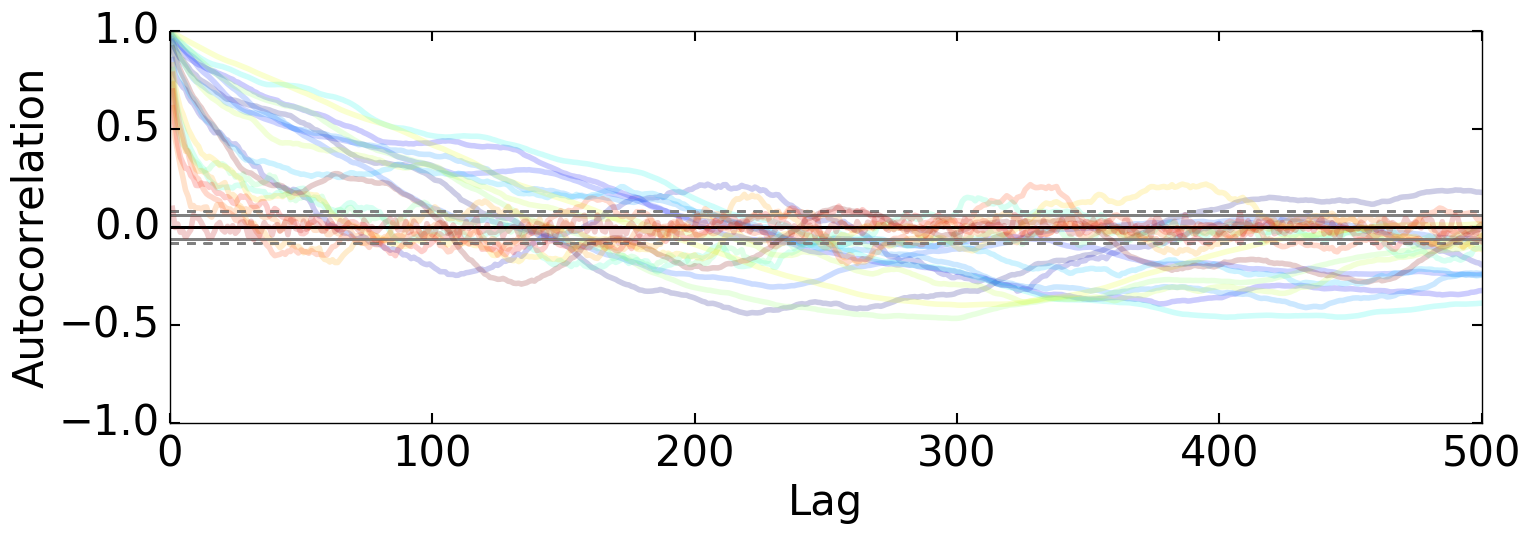

In [68]:
Nburnin = 1000 # burn-in
indices = argsort(train4_samples[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest weights

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(train4_samples[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, (Nmcmc-Nburnin)/2])
tight_layout()

In [69]:
Nthin = 50 # thinning
z4_samples_t = z4_samples[Nburnin::Nthin]

Let's examine some samples to see how we've done.

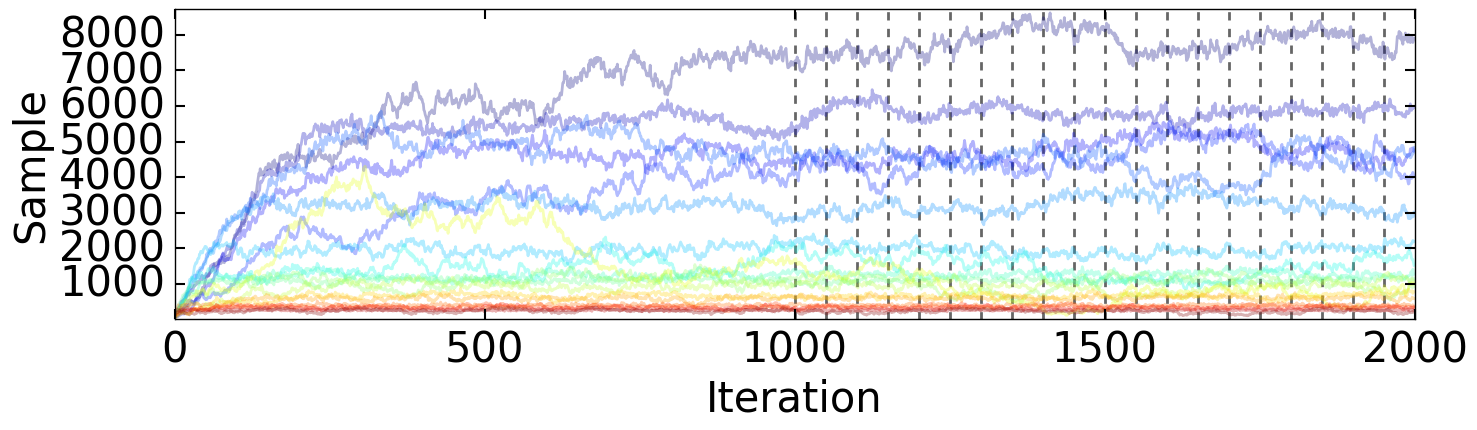

In [70]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), train4_samples[:,idx], color=colors[i], lw=2, alpha=0.3)
vlines(arange(Nmcmc)[Nburnin::Nthin], 0, 1e6, color='black', linestyles='--', alpha=0.6, lw=2)
ylim([train4_samples[Nburnin:,indices[:20]].min()-100, train4_samples[Nburnin:,indices[:20]].max()+100])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

We notice something interesting here: our hierarchical model is telling us one object contributes 8% to the overall posterior, while the top 20/1000 contribute around 70%! Our basis is thus quite redundant, with some objects much more important than others.

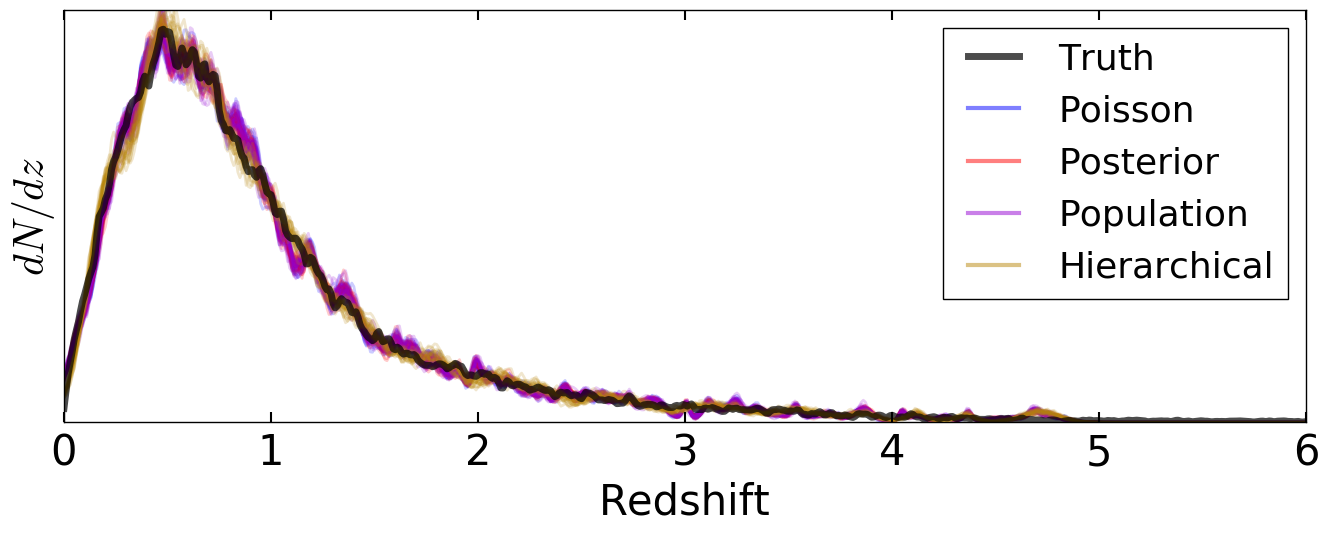

In [71]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, z1_samples[i], lw=2, color='blue', alpha=0.2) for i in xrange(Nsamples)]
[plot(zgrid, z2_samples[i], lw=2, color='red', alpha=0.2) for i in xrange(Nsamples)]
[plot(zgrid, z3_samples[i], lw=2, color='darkviolet', alpha=0.2) for i in xrange(Nsamples)]
[plot(zgrid, z4_samples_t[i], lw=2, color='darkgoldenrod', alpha=0.2) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Population')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.05])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

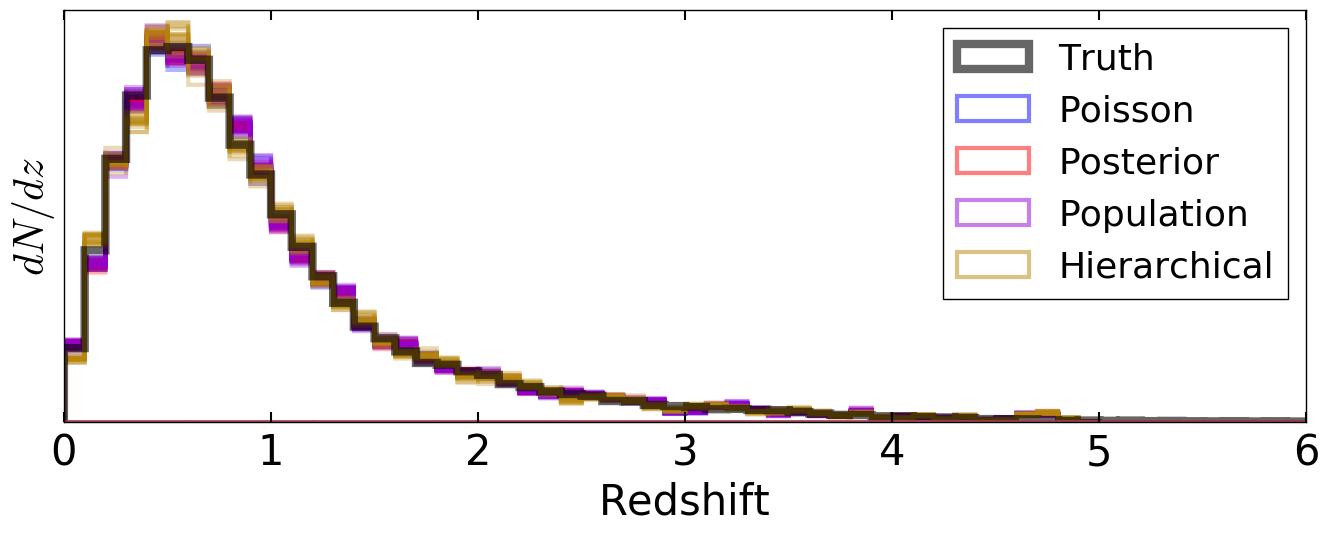

In [72]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=z1_samples[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z2_samples[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z3_samples[i], lw=3, histtype='step', color='darkviolet', alpha=0.3) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z4_samples_t[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in xrange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = pdf/pdf.sum() * Nobs, histtype='step', 
         lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Population')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

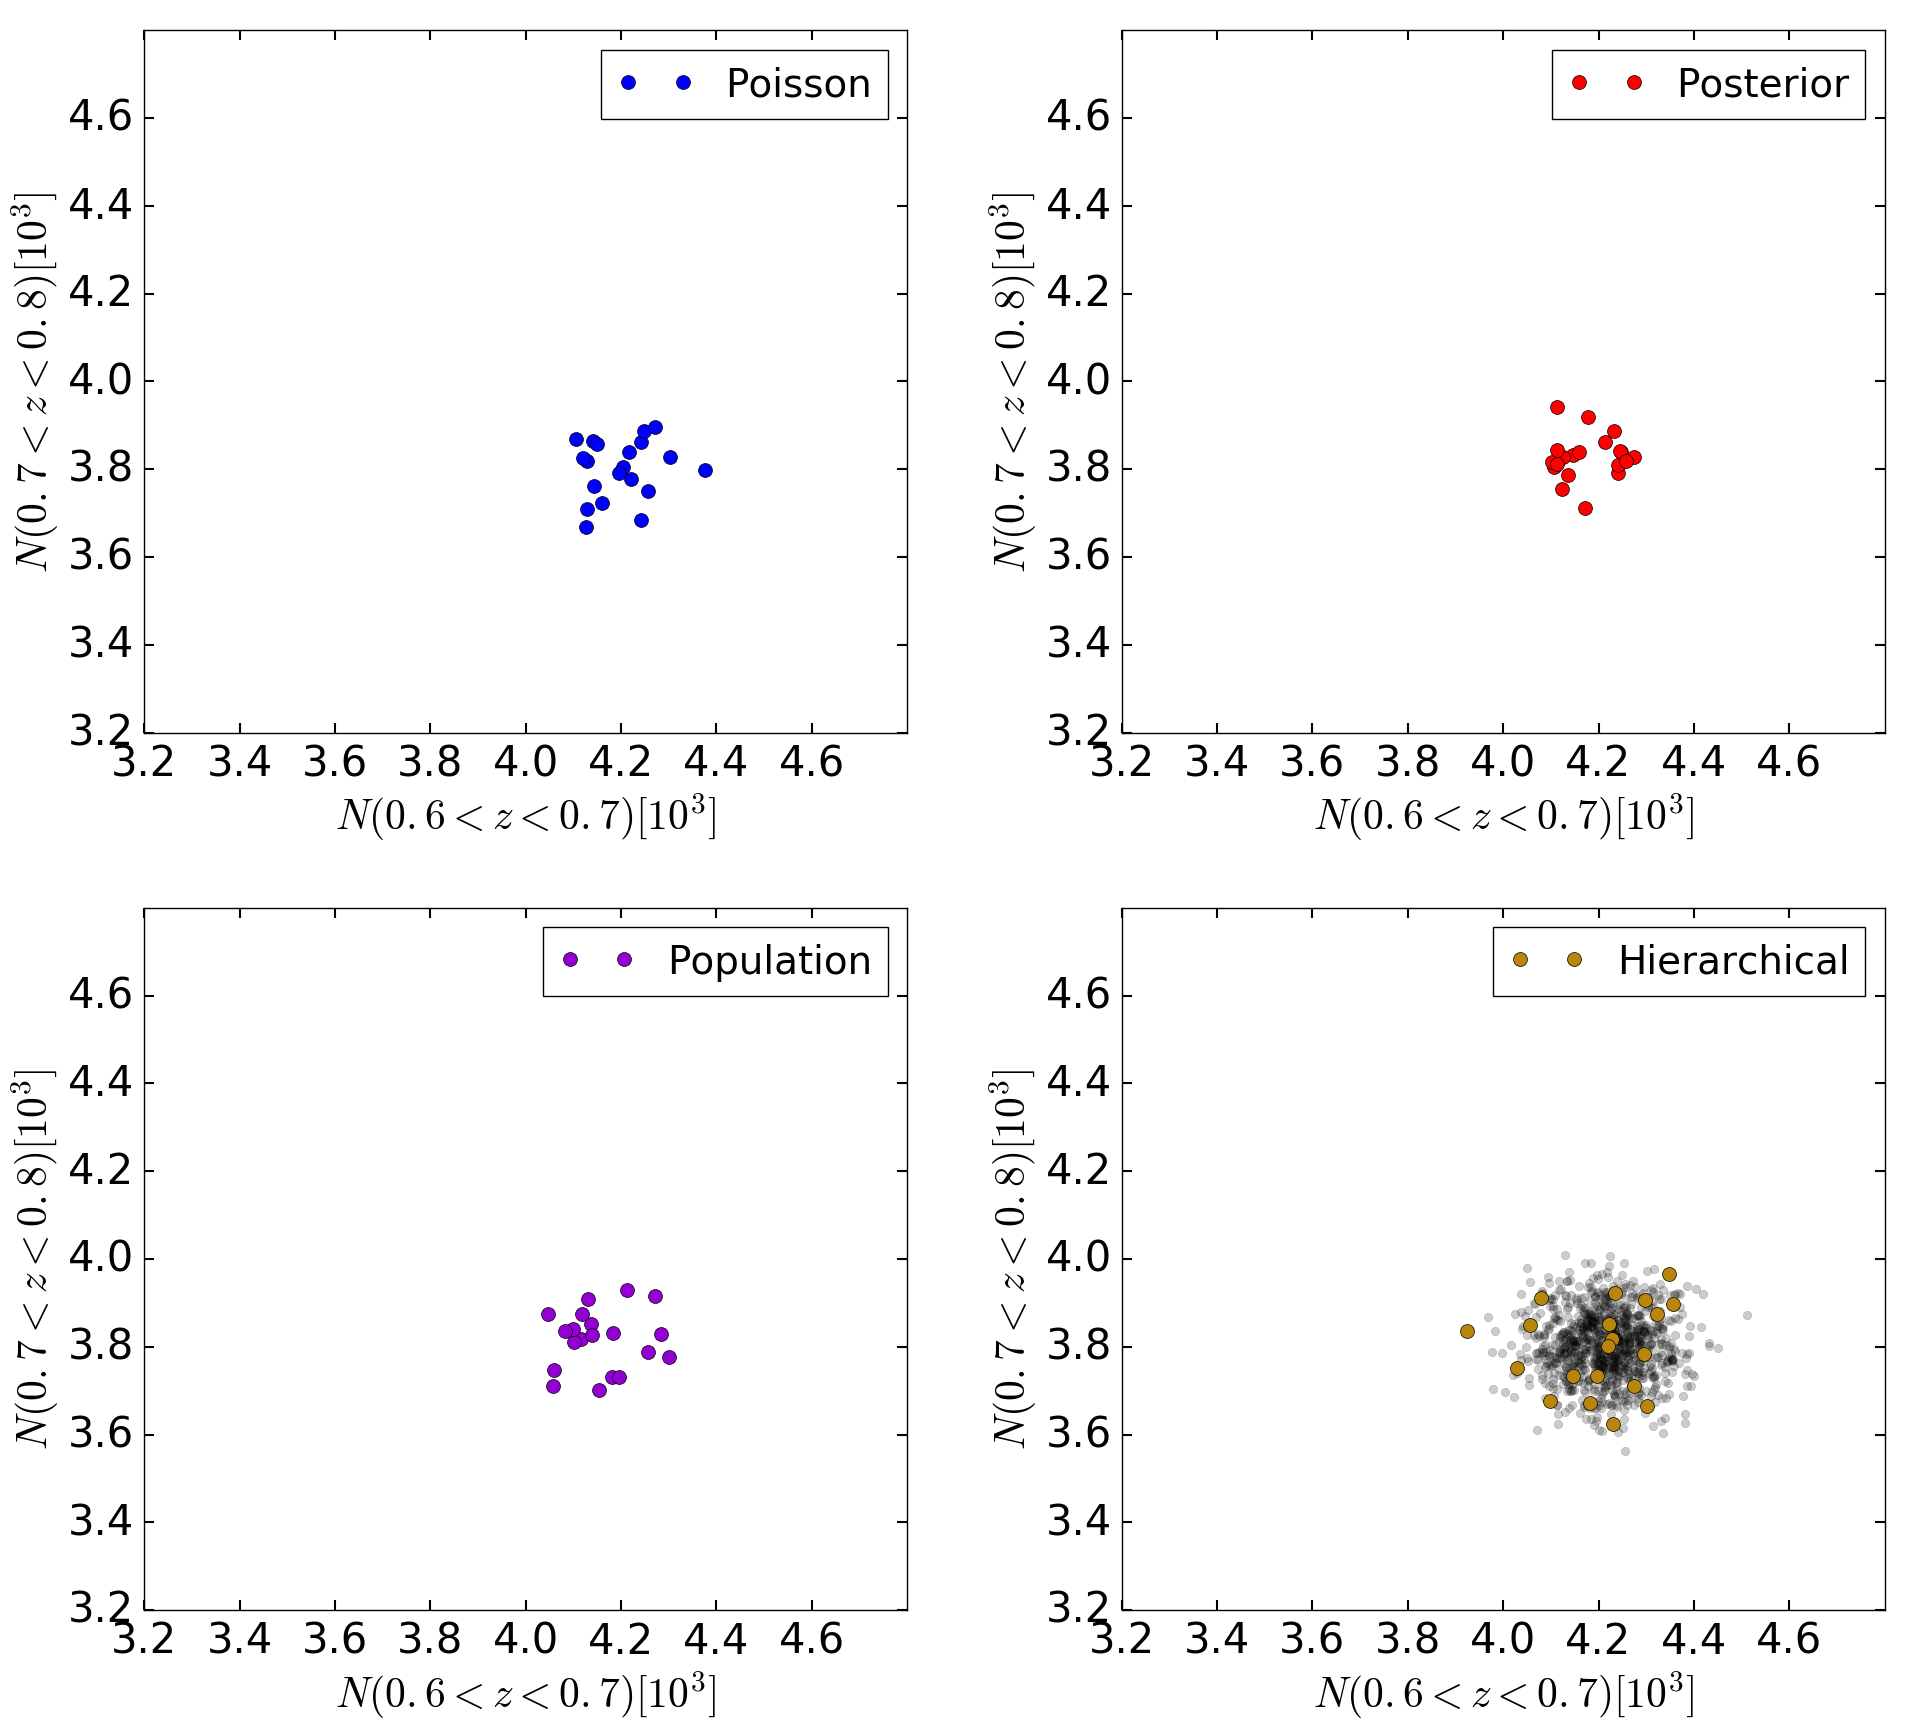

In [74]:
figure(figsize=(20,18))
subplot(2,2,1)
plot(z1_samples[:,60:70].sum(axis=1)/1e3, z1_samples[:,70:80].sum(axis=1)/1e3, 'o', color='blue', label='Poisson', 
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
plot(z2_samples[:,60:70].sum(axis=1)/1e3, z2_samples[:,70:80].sum(axis=1)/1e3, 'o', color='red', label='Posterior',
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
plot(z3_samples[:,60:70].sum(axis=1)/1e3, z3_samples[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', label='Population',
     markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
plot(z4_samples[Nburnin:,60:70].sum(axis=1)/1e3, z4_samples[Nburnin:,70:80].sum(axis=1)/1e3, 'o', 
     color='black', alpha=0.2)
plot(z4_samples_t[:,60:70].sum(axis=1)/1e3, z4_samples_t[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=10)
ylim([3.2, 4.8])
xlim([3.2, 4.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

We see similar behavior to our original model, except with less extreme variation between draws.